In [26]:
# Import libraries yang diperlukan
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# LDA and vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models

import pandas as pd

# Download NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')

print("Libraries imported successfully!")

Libraries imported successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Load dataset
df = pd.read_excel('Al-Ikhlash Aspek_db.xlsx')  # Ganti dengan path file Anda

# Tampilkan informasi dasar dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

# Cek missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Fokus pada kolom yang akan digunakan
required_columns = ['no', 'nama', 'kalimat', 'tema_postingan', 'ponpes', 'aspek_manual']
print(f"\nRequired columns present: {all(col in df.columns for col in required_columns)}")

# Preview data text
print("\nSample text from 'kalimat':")
print(df['kalimat'].head(3).tolist())
print("\nSample text from 'tema_postingan':")
print(df['tema_postingan'].head(3).tolist())

Dataset Shape: (344, 6)

Column Names: ['no', 'nama', 'kalimat', 'tema_postingan', 'ponpes', 'aspek_manual']

First 5 rows:
   no                nama                                            kalimat  \
0   1           Iyya Fhia                                         MasyaAllah   
1   2         Isnan Ihsan                           Pimpinan Pondok terkeren   
2   3  Paud Tigaserangkai                     Sehat selalu pak ustaz. Aamiin   
3   4          Nur Aliyah  Semangat anak solehnya ummi..d mudahkan nak..d...   
4   5      Nurlina Suardi                                         MasyaAllah   

                                      tema_postingan                  ponpes  \
0  SANTRI PPM AL-IKHLASH SERAHKAN BANTUAN UNTUK K...  PPM AL-Ikhlash Lampoko   
1  Pimpinan Al-Ikhlash Menerima Kunjungan Penguru...  PPM AL-Ikhlash Lampoko   
2  Pimpinan Al-Ikhlash Menerima Kunjungan Penguru...  PPM AL-Ikhlash Lampoko   
3  Alhamdulillah., Ananda Muh. Dzaki As Syafiq ak...  PPM AL-Ikhlash Lampok

In [28]:
# Setup Indonesian text processing
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_factory = StopWordRemoverFactory()
stopword_remover = stop_factory.create_stop_word_remover()

# Function untuk cleaning text
def clean_text(text):
    """
    Membersihkan text dari punctuation, numbers, dan special characters
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Function untuk remove stopwords
def remove_stopwords(text):
    """
    Menghapus stopwords bahasa Indonesia
    """
    return stopword_remover.remove(text)

# Function untuk stemming
def stem_text(text):
    """
    Melakukan stemming pada text bahasa Indonesia
    """
    return stemmer.stem(text)

# Function untuk complete preprocessing
def preprocess_text(text):
    """
    Complete text preprocessing pipeline
    """
    # Clean text
    cleaned = clean_text(text)
    
    # Remove stopwords
    no_stopwords = remove_stopwords(cleaned)
    
    # Stemming
    stemmed = stem_text(no_stopwords)
    
    return stemmed

# Test preprocessing function
sample_text = "Guru-guru di pondok pesantren sangat baik dan ramah kepada para santri."
print("Original:", sample_text)
print("Processed:", preprocess_text(sample_text))

Original: Guru-guru di pondok pesantren sangat baik dan ramah kepada para santri.
Processed: guru guru pondok pesantren sangat baik ramah para santri


In [29]:
# Apply preprocessing ke kolom 'kalimat' dan 'tema_postingan'
print("Preprocessing 'kalimat' column...")
df['kalimat_processed'] = df['kalimat'].apply(preprocess_text)

print("Preprocessing 'tema_postingan' column...")
df['tema_postingan_processed'] = df['tema_postingan'].apply(preprocess_text)

# Cek hasil preprocessing
print("\nSample processed texts:")
for i in range(3):
    print(f"\nRow {i+1}:")
    print(f"Original kalimat: {df['kalimat'].iloc[i]}")
    print(f"Processed kalimat: {df['kalimat_processed'].iloc[i]}")
    print(f"Original tema_postingan: {df['tema_postingan'].iloc[i]}")
    print(f"Processed tema_postingan: {df['tema_postingan_processed'].iloc[i]}")

# Remove empty texts
df = df[(df['kalimat_processed'].str.len() > 0) | (df['tema_postingan_processed'].str.len() > 0)]
print(f"\nDataset shape after removing empty texts: {df.shape}")

Preprocessing 'kalimat' column...
Preprocessing 'tema_postingan' column...

Sample processed texts:

Row 1:
Original kalimat: MasyaAllah
Processed kalimat: masyaallah
Original tema_postingan: SANTRI PPM AL-IKHLASH SERAHKAN BANTUAN UNTUK KORBAN KEBAKARAN DI DESA BONNE-BONNE
Processed tema_postingan: santri ppm al ikhlash serah bantu korban bakar desa bonne bonne

Row 2:
Original kalimat: Pimpinan Pondok terkeren
Processed kalimat: pimpin pondok keren
Original tema_postingan: Pimpinan Al-Ikhlash Menerima Kunjungan Pengurus KKS (Kerukunan Keluarga Sulawesi) Kairo
Processed tema_postingan: pimpin al ikhlash terima kunjung urus kks rukun keluarga sulawesi kairo

Row 3:
Original kalimat: Sehat selalu pak ustaz. Aamiin
Processed kalimat: sehat selalu pak ustaz aamiin
Original tema_postingan: Pimpinan Al-Ikhlash Menerima Kunjungan Pengurus KKS (Kerukunan Keluarga Sulawesi) Kairo
Processed tema_postingan: pimpin al ikhlash terima kunjung urus kks rukun keluarga sulawesi kairo

Dataset shape aft

In [30]:
# Combine preprocessed text features
def combine_features(row):
    """
    Menggabungkan kalimat dan tema_postingan yang sudah dipreprocess
    """
    kalimat = row['kalimat_processed'] if pd.notna(row['kalimat_processed']) else ""
    tema = row['tema_postingan_processed'] if pd.notna(row['tema_postingan_processed']) else ""
    
    # Combine with separator
    combined = f"{kalimat} {tema}".strip()
    return combined

# Apply feature combination
df['combined_text'] = df.apply(combine_features, axis=1)

# Remove documents with very short combined text
min_words = 3
df = df[df['combined_text'].str.split().str.len() >= min_words]

print(f"Dataset shape after filtering short texts: {df.shape}")
print("\nSample combined texts:")
for i in range(3):
    print(f"Row {i+1}: {df['combined_text'].iloc[i]}")

# Reset index
df = df.reset_index(drop=True)

Dataset shape after filtering short texts: (342, 9)

Sample combined texts:
Row 1: masyaallah santri ppm al ikhlash serah bantu korban bakar desa bonne bonne
Row 2: pimpin pondok keren pimpin al ikhlash terima kunjung urus kks rukun keluarga sulawesi kairo
Row 3: sehat selalu pak ustaz aamiin pimpin al ikhlash terima kunjung urus kks rukun keluarga sulawesi kairo


In [31]:
# Prepare documents for vectorization
documents = df['combined_text'].tolist()

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,          # Maximum number of features
    min_df=2,                   # Minimum document frequency
    max_df=0.8,                 # Maximum document frequency
    ngram_range=(1, 2),         # Unigrams and bigrams
    lowercase=True
)

# Fit and transform documents
print("Creating TF-IDF representation...")
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")

Creating TF-IDF representation...
TF-IDF Matrix Shape: (342, 848)
Number of features: 848

Sample features: ['aamiin' 'aamiin final' 'aamiin santri' 'aamiin selamat' 'aamiin xd'
 'abdi' 'abdi negara' 'ada' 'ada rumah' 'agustus' 'ainun' 'ainun aulia'
 'ajang' 'ajang bal' 'ajang lomba' 'ajang olimpiade' 'ajar'
 'ajar sulawesi' 'akhir' 'akhir semester']


In [32]:
# Alternative: Create Bag-of-Words using CountVectorizer
count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    lowercase=True
)

# Fit and transform documents
print("Creating Bag-of-Words representation...")
bow_matrix = count_vectorizer.fit_transform(documents)

print(f"BoW Matrix Shape: {bow_matrix.shape}")
print(f"Number of features: {len(count_vectorizer.get_feature_names_out())}")

Creating Bag-of-Words representation...
BoW Matrix Shape: (342, 848)
Number of features: 848


In [33]:
# Set number of topics
n_topics = 9

# Create and fit LDA model using sklearn
print("Training LDA model...")
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=20,
    learning_method='online',
    learning_offset=50.0,
    doc_topic_prior=0.1,    # Alpha parameter
    topic_word_prior=0.01   # Beta parameter
)

# Fit the model on TF-IDF matrix
lda_model.fit(tfidf_matrix)

print("LDA model training completed!")
print(f"Log likelihood: {lda_model.score(tfidf_matrix)}")
print(f"Perplexity: {lda_model.perplexity(tfidf_matrix)}")

Training LDA model...
LDA model training completed!
Log likelihood: -19877.38967690021
Perplexity: 547837.9480389275


In [34]:
# Function to get top words for each topic
def get_topic_words(model, feature_names, n_words=10):
    """
    Extract top words for each topic
    """
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[topic_idx] = top_words
    return topics

# Get topic words
topic_words = get_topic_words(lda_model, feature_names, n_words=15)

# Display topics
print("Topics and their top words:")
for topic_id, words in topic_words.items():
    print(f"\nTopic {topic_id}: {', '.join(words)}")

Topics and their top words:

Topic 0: al, santri, ppm al, ppm, yel, ikhlash, al ikhlash, allah, masya, moga, santri ppm, fahmi, masya allah, mesir, pondok

Topic 1: selamat sukses, selamat, sukses, pilih, telah, ihsan zainuddin, zainuddin, ihsan, ospi, ketua, ketua ospi, serta, pimpin pondok, pimpin, quro

Topic 2: serah piagam, piagam, harga, piagam harga, serah, para, jadi, muslim, selamat, nak, masuk pondok, ikhlash alhamdulillah, temanta saudarata, biar bangga, muslim pilih

Topic 3: gerak, gerak jalan, jalan, lomba, lomba gerak, smps, juara, smps al, ajang, juara ajang, ajang lomba, lampoko juara, alhamdulilah, alhamdulilah smps, lampoko

Topic 4: pura, pura pura, pura sakit, sakit, umum, yg, anak, pondok, dlm, kasih, terima kasih, ingat, jdi, santri yg, ustadz

Topic 5: tanding, live, putri, silat, silat antar, pencak, pencak silat, antar putri, tanding pencak, putri live, antar, agustus, upacara agustus, suasana upacara, suasana

Topic 6: muslim, putra, ospi putra, ketua, ospi, 

In [35]:
# Define aspect mapping
# Anda perlu menyesuaikan mapping ini berdasarkan hasil topics yang diperoleh
aspect_mapping = {
    0: "Kualitas Guru",
    1: "Sosial", 
    2: "Motivasi/Spiritual",
    3: "Kegiatan Pondok",
    4: "Akademik",
    5: "Umum",
    6: "Fasilitas",
    7: "Lingkungan",
    8: "Pembinaan Karakter"
}

# Display mapping
print("Topic to Aspect Mapping:")
for topic_id, aspect in aspect_mapping.items():
    print(f"Topic {topic_id} -> {aspect}")
    print(f"Keywords: {', '.join(topic_words[topic_id][:10])}")
    print()

# Note: Anda mungkin perlu menyesuaikan mapping ini berdasarkan 
# analisis manual dari keywords yang dihasilkan

Topic to Aspect Mapping:
Topic 0 -> Kualitas Guru
Keywords: al, santri, ppm al, ppm, yel, ikhlash, al ikhlash, allah, masya, moga

Topic 1 -> Sosial
Keywords: selamat sukses, selamat, sukses, pilih, telah, ihsan zainuddin, zainuddin, ihsan, ospi, ketua

Topic 2 -> Motivasi/Spiritual
Keywords: serah piagam, piagam, harga, piagam harga, serah, para, jadi, muslim, selamat, nak

Topic 3 -> Kegiatan Pondok
Keywords: gerak, gerak jalan, jalan, lomba, lomba gerak, smps, juara, smps al, ajang, juara ajang

Topic 4 -> Akademik
Keywords: pura, pura pura, pura sakit, sakit, umum, yg, anak, pondok, dlm, kasih

Topic 5 -> Umum
Keywords: tanding, live, putri, silat, silat antar, pencak, pencak silat, antar putri, tanding pencak, putri live

Topic 6 -> Fasilitas
Keywords: muslim, putra, ospi putra, ketua, ospi, selamat muslim, xi merdeka, santri kelas, muslim santri, merdeka ketua

Topic 7 -> Lingkungan
Keywords: duta, ajar sulawesi, duta ajar, sulawesi, pilih duta, ajar, sulawesi barat, barat, final

In [36]:
# Get document-topic probabilities
doc_topic_probs = lda_model.transform(tfidf_matrix)

# Find the dominant topic for each document
dominant_topics = np.argmax(doc_topic_probs, axis=1)

# Get the probability of the dominant topic
dominant_topic_probs = np.max(doc_topic_probs, axis=1)

# Add results to dataframe
df['predicted_topic'] = dominant_topics
df['topic_probability'] = dominant_topic_probs
df['predicted_aspect'] = df['predicted_topic'].map(aspect_mapping)

# Display results
print("Sample predictions:")
sample_results = df[['kalimat', 'tema_postingan', 'predicted_topic', 
                    'predicted_aspect', 'topic_probability']].head(10)
print(sample_results)

Sample predictions:
                                             kalimat  \
0                                         MasyaAllah   
1                           Pimpinan Pondok terkeren   
2                     Sehat selalu pak ustaz. Aamiin   
3  Semangat anak solehnya ummi..d mudahkan nak..d...   
4                                         MasyaAllah   
5  Aamiin...semoga kegiatan ini di lancarkan dan ...   
6  Aamiin 🤲🏻🤲🏻🤲🏻_x000D_\nSemoga dimudahkan dan di...   
7       MasyaAllah....semoga dimudahkan nak.. 🤲🤲🤲🤗🤗🤗   
8                                       MasyaAllah 🤗   
9                    Semangat &sukses ya nak. Aamiin   

                                      tema_postingan  predicted_topic  \
0  SANTRI PPM AL-IKHLASH SERAHKAN BANTUAN UNTUK K...                0   
1  Pimpinan Al-Ikhlash Menerima Kunjungan Penguru...                7   
2  Pimpinan Al-Ikhlash Menerima Kunjungan Penguru...                7   
3  Alhamdulillah., Ananda Muh. Dzaki As Syafiq ak...                0  

Distribution of predicted aspects:
aspek_manual
Umum                  95
Kegiatan Pondok       73
Kualitas Guru         66
Pembinaan Karakter    35
Lingkungan            30
Sosial                29
Akademik               6
Motivasi/Spiritual     4
Fasilitas              4
Name: count, dtype: int64


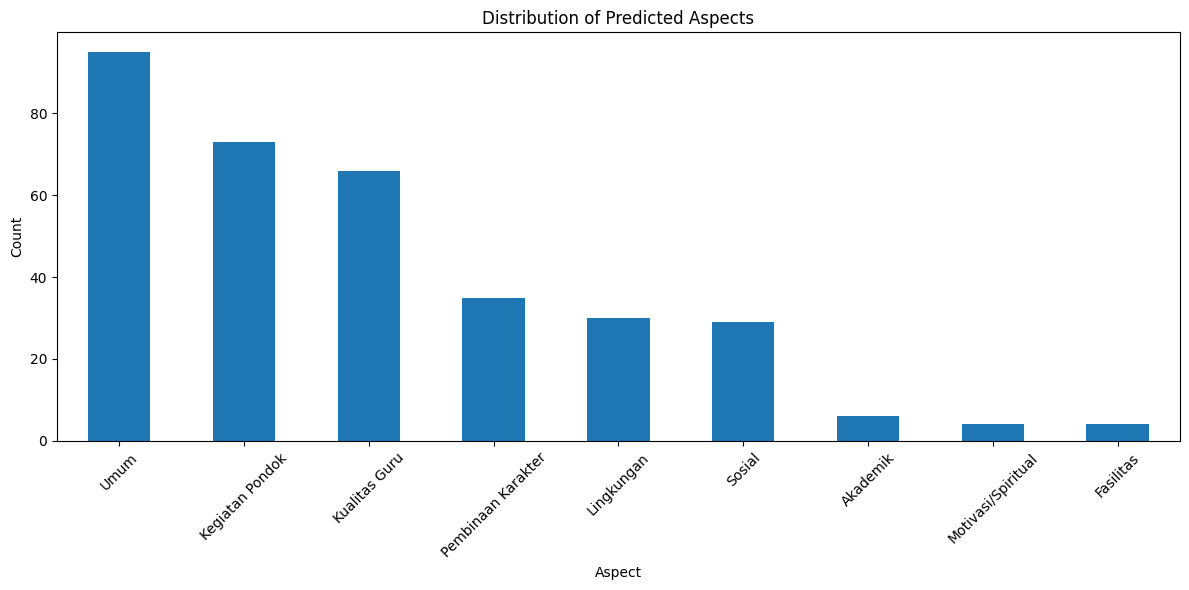

In [37]:
# Update aspek_manual column with predictions
# Assuming you want to overwrite existing values
df['aspek_manual'] = df['predicted_aspect']

# Or, only fill empty values in aspek_manual
# df['aspek_manual'] = df['aspek_manual'].fillna(df['predicted_aspect'])

# Display distribution of predicted aspects
print("Distribution of predicted aspects:")
aspect_counts = df['aspek_manual'].value_counts()
print(aspect_counts)

# Plot distribution
plt.figure(figsize=(12, 6))
aspect_counts.plot(kind='bar', rot=45)
plt.title('Distribution of Predicted Aspects')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Average topic coherence: 0.811


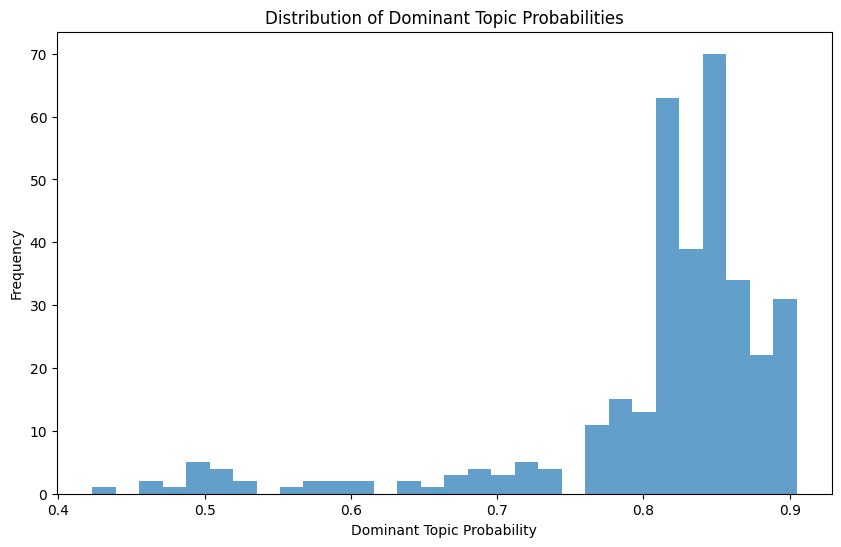

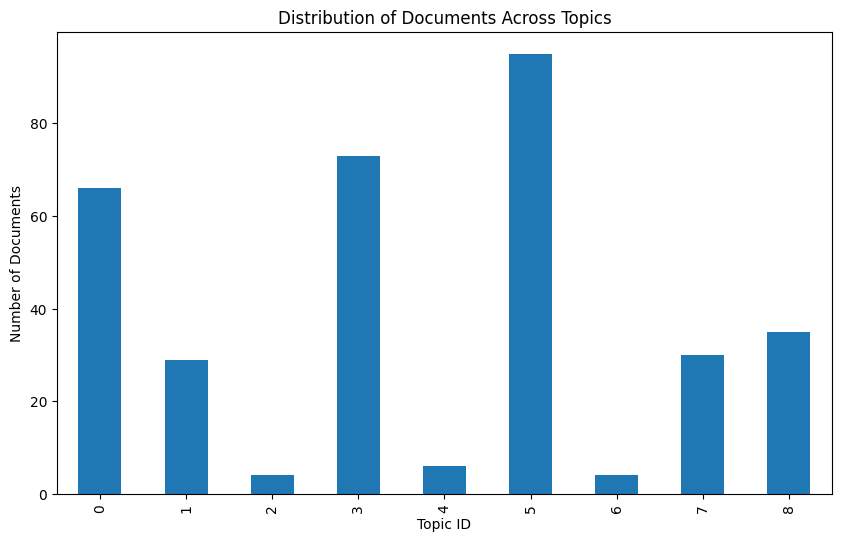

In [38]:
# Topic coherence analysis
def calculate_topic_coherence(doc_topic_probs):
    """
    Calculate average topic coherence
    """
    # Calculate how concentrated each document is on its dominant topic
    max_probs = np.max(doc_topic_probs, axis=1)
    avg_coherence = np.mean(max_probs)
    return avg_coherence

coherence_score = calculate_topic_coherence(doc_topic_probs)
print(f"Average topic coherence: {coherence_score:.3f}")

# Distribution of topic probabilities
plt.figure(figsize=(10, 6))
plt.hist(dominant_topic_probs, bins=30, alpha=0.7)
plt.xlabel('Dominant Topic Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Dominant Topic Probabilities')
plt.show()

# Topic distribution
topic_distribution = pd.Series(dominant_topics).value_counts().sort_index()
plt.figure(figsize=(10, 6))
topic_distribution.plot(kind='bar')
plt.xlabel('Topic ID')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Topics')
plt.show()

In [39]:
# If results are not satisfactory, try different parameters

# Option 1: Try different number of topics
def try_different_topics(tfidf_matrix, feature_names, topic_range=[5, 7, 9, 11, 13]):
    """
    Try different number of topics and compare results
    """
    results = {}
    
    for n_topics in topic_range:
        print(f"\nTrying {n_topics} topics...")
        
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=20
        )
        
        lda.fit(tfidf_matrix)
        perplexity = lda.perplexity(tfidf_matrix)
        
        results[n_topics] = {
            'model': lda,
            'perplexity': perplexity
        }
        
        print(f"Perplexity: {perplexity:.2f}")
    
    return results

# Uncomment to try different numbers of topics
# topic_results = try_different_topics(tfidf_matrix, feature_names)

In [ ]:
# ini program yang menambahkan 2 file: pertama file resul dari model dan kedua file yang tetap sama kolomnya kecuali asspek manual
# Save the final dataset with predictions
output_filename = 'dataset_with_predictions.csv'
df.to_csv(output_filename, index=False)
print(f"Results saved to {output_filename}")

# Create result file with original structure + predicted aspects
result_df = df[['no', 'nama', 'kalimat', 'tema_postingan', 'ponpes']].copy()
result_df['aspek_manual'] = df['predicted_aspect']  # Isi aspek_manual dengan hasil prediksi

# Save to Excel file
excel_filename = 'hasil_prediksi_aspek.xlsx'
result_df.to_excel(excel_filename, index=False, engine='openpyxl')
print(f"Excel result file saved to {excel_filename}")

# Save to CSV format as well
# csv_filename = 'hasil_prediksi_aspek.csv'
# result_df.to_csv(csv_filename, index=False)
# print(f"CSV result file saved to {csv_filename}")

# Display preview of result file
print(f"\nPreview of {excel_filename}:")
print(result_df.head())
print(f"\nColumns in result file: {result_df.columns.tolist()}")
print(f"Shape of result file: {result_df.shape}")

# Save topic information
topic_info = []
for topic_id, words in topic_words.items():
    topic_info.append({
        'topic_id': topic_id,
        'aspect': aspect_mapping[topic_id],
        'top_words': ', '.join(words[:10]),
        'document_count': (dominant_topics == topic_id).sum()
    })

topic_df = pd.DataFrame(topic_info)
# topic_df.to_csv('topic_analysis.csv', index=False)
topic_df.to_excel('topic_analysis.xlsx', index=False, engine='openpyxl')
print("Topic analysis saved to topic_analysis.csv and topic_analysis.xlsx")

# Display final summary
print("\nFinal Summary:")
print(f"Total documents processed: {len(df)}")
print(f"Number of topics: {n_topics}")
print(f"Average topic probability: {np.mean(dominant_topic_probs):.3f}")
print("\nAspect distribution in result file:")
print(result_df['aspek_manual'].value_counts())

# Save detailed results with probabilities (optional)
detailed_result = result_df.copy()
detailed_result['predicted_topic_id'] = df['predicted_topic']
detailed_result['topic_probability'] = df['topic_probability']
detailed_result['combined_text_processed'] = df['combined_text']

detailed_filename = 'hasil_prediksi_aspek_detailed.xlsx'
detailed_result.to_excel(detailed_filename, index=False, engine='openpyxl')
print(f"Detailed result with probabilities saved to {detailed_filename}")

print(f"\nFiles created:")
print(f"1. {excel_filename} - Main result file (original structure + predicted aspects)")
print(f"2. {csv_filename} - Same as above in CSV format")
print(f"3. {detailed_filename} - Detailed results with topic probabilities")
print(f"4. topic_analysis.xlsx - Topic analysis and mapping information")
print(f"5. {output_filename} - Complete dataset with all processing columns")

Results saved to dataset_with_predictions.csv
Excel result file saved to hasil_prediksi_aspek.xlsx
CSV result file saved to hasil_prediksi_aspek.csv

Preview of hasil_prediksi_aspek.xlsx:
   no                nama                                            kalimat  \
0   1           Iyya Fhia                                         MasyaAllah   
1   2         Isnan Ihsan                           Pimpinan Pondok terkeren   
2   3  Paud Tigaserangkai                     Sehat selalu pak ustaz. Aamiin   
3   4          Nur Aliyah  Semangat anak solehnya ummi..d mudahkan nak..d...   
4   5      Nurlina Suardi                                         MasyaAllah   

                                      tema_postingan                  ponpes  \
0  SANTRI PPM AL-IKHLASH SERAHKAN BANTUAN UNTUK K...  PPM AL-Ikhlash Lampoko   
1  Pimpinan Al-Ikhlash Menerima Kunjungan Penguru...  PPM AL-Ikhlash Lampoko   
2  Pimpinan Al-Ikhlash Menerima Kunjungan Penguru...  PPM AL-Ikhlash Lampoko   
3  Alhamdul